## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.


* NB: if `PIL` is not installed, try `conda install pillow`.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request

import numpy as np
from PIL import Image

%matplotlib inline

### Download the Model
We provide you a pretrained model `ResNet-34` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **ResNet-34**: A deep architecture for image classification.

In [5]:
resnet34 = models.resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')  # New PyTorch interface for loading weights!
resnet34.eval() # set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)


Input image must be of size (3x224x224). 

First convolution layer with maxpool. 
Then 4 ResNet blocks. 

Output of the last ResNet block is of size (512x7x7). 

Average pooling is applied to this layer to have a 1D array of 512 features fed to a linear layer that outputs 1000 values (one for each class). No softmax is present in this case. We have already the raw class score!

In [6]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

##classes is a dictionary with the name of each class 
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [7]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # Note: If the inverse normalisation is required, apply 1/x to the above object
    
    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [8]:
import os
# if not os.path.exists("data"):
#     os.mkdir("data")
# if not os.path.exists("data/TP2_images"):
#     os.mkdir("data/TP2_images")
#     !cd data/TP2_images && wget "https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip" && unzip TP2_images.zip

dir_path = "data/" 
dataset = preprocess_image(dir_path)

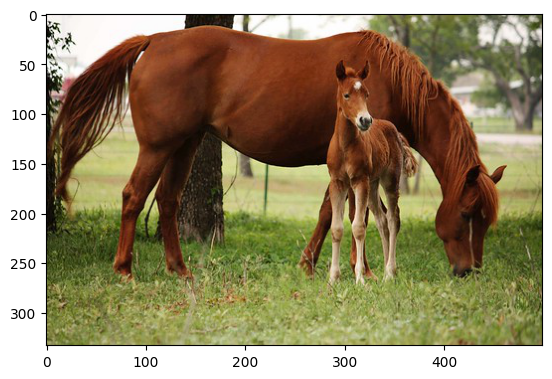

In [9]:
# show the orignal image 
index = 10
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

In [10]:
output = resnet34(dataset[index][0].view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [339 345 253] ['sorrel', 'ox', 'basenji']
Raw class scores: [16.298988  8.744853  8.430347]


### Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 


* **To be submitted within 2 weeks**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully.
 + More on [autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html) and [hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks)
 + The pretrained model resnet34 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. 
 + The size of feature maps is 7x7, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

Class: ‘pug, pug-dog’ | Class: ‘tabby, tabby cat’
- | - 
![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dog.jpg)| ![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/cat.jpg)

In [19]:
def Grad_CAM(model, input_image):
    # compute first three top classes
    output = model(input_image)
    target_values, target_indices = torch.topk(output, 3)
    target_values = target_values[0].detach().numpy()
    target_indices = target_indices[0].detach().numpy()
    target_probabilities = (
        F.softmax(torch.tensor(target_values), dim=0).detach().numpy()
    )

    print("Top 3-classes:", target_indices, [classes[x] for x in target_indices])
    print("Raw class scores:", target_values)
    print("Probabilities:", target_probabilities)

    # register hooks
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output

        return hook

    activation_grad = {}

    def get_activation_grad(name):
        def hook(model, grad_input, grad_output):
            activation_grad[name] = grad_output

        return hook

    for module_name, module in dict(model.named_modules()).items():
        module.register_forward_hook(get_activation(module_name))
        module.register_backward_hook(get_activation_grad(module_name))

    fig, axes = plt.subplots(1, len(target_indices) + 1, figsize=(15, 5))

    # unnormalize input image
    input_image_unnormalized = input_image.detach().numpy().squeeze().transpose(1, 2, 0)
    input_image_unnormalized = input_image_unnormalized * [0.229, 0.224, 0.225]
    input_image_unnormalized = input_image_unnormalized + [0.485, 0.456, 0.406]
    input_image_unnormalized = input_image_unnormalized * 255.0

    # show the orignal image
    axes[0].imshow(input_image_unnormalized.astype(np.uint8))
    axes[0].set_title("Original image")
    axes[0].axis("off")

    for it, target_index in enumerate(target_indices):
        model.zero_grad()

        # forward pass
        output = model(input_image)

        # backward pass
        output_grad = torch.zeros_like(output)
        output_grad[0, target_index] = 1
        output.backward(gradient=output_grad)

        # get the last convolutional layer
        last_conv_layer = activation["layer4"][0]
        # get the gradients of the last convolutional layer
        last_conv_layer_grad = activation_grad["layer4"][0]
        # compute the neuron importance weights
        neuron_importance_weights = last_conv_layer_grad.mean(axis=(0, 2, 3))
        # compute the weighted combination of the convolutional maps
        weighted_combination = (
            last_conv_layer * neuron_importance_weights.reshape(-1, 1, 1)
        ).sum(axis=0)
        # go through ReLU
        weighted_combination = np.maximum(weighted_combination.detach().numpy(), 0)
        # normalize the heatmap
        weighted_combination = (weighted_combination - weighted_combination.min()) / (
            weighted_combination.max() - weighted_combination.min()
        )
        # resize the heatmap to the size of the input image
        weighted_combination = Image.fromarray(
            (weighted_combination * 255).astype(np.uint8)
        ).resize(input_image.shape[-2:])

        # show the Grad-CAM output
        axes[it + 1].imshow(weighted_combination, cmap="jet", alpha=0.6)
        axes[it + 1].imshow(input_image_unnormalized.astype(np.uint8), alpha=0.4)
        axes[it + 1].set_title(
            f"Target index: {target_index} ({classes[target_index]}) | Probability: {target_probabilities[it]:.2f}",
            fontsize=6,
        )
        axes[it + 1].axis("off")

    plt.tight_layout()
    plt.show()

Top 3-classes: [339 345 253] ['sorrel', 'ox', 'basenji']
Raw class scores: [16.298988  8.744853  8.430347]
Probabilities: [9.9909437e-01 5.2346446e-04 3.8220748e-04]


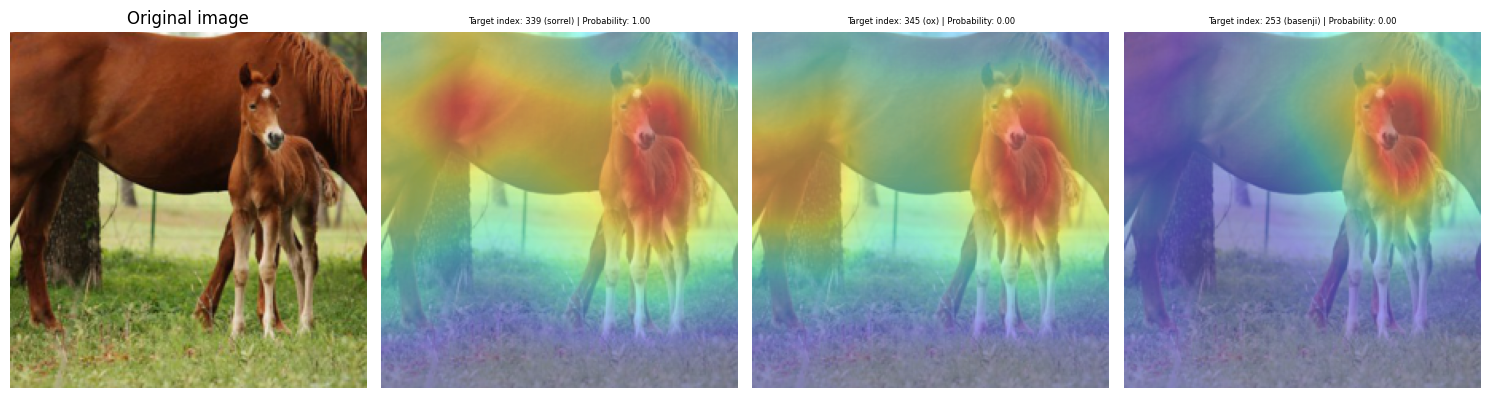

In [20]:
# test Grad_CAM
index = 10
heatmap = Grad_CAM(resnet34, dataset[index][0].view(1, 3, 224, 224))

Here, we show Grad-CAM heatmaps for the top 4 classes for the given images. The heatmaps are shown with the corresponding resized images. The heatmaps are superimposed on the images with the jet colormap. The heatmaps are normalized by min-max scaling. The images are normalized by mean and standard deviation before feeding to the model.

For the picture of index 7, we clearly notice that the heatmaps of all the first labels are centered on the heads of the two dogs. We can probably infer that they are the most important features to identify the subject of the picture as a dog.

The label which comes first, "Great Dane", has a heatmap that is more focused on the head of the dog in the foreground, while the third label, "Chesapeak Bay Retriever", has a heatmap that is more focused on the head of the dog in the background. Indeed, it seems that the dog in the foreground is a Great Dane, whereas the dog in the background is a Chesapeak Bay Retriever.

### Complementary questions:

##### Try GradCAM on others convolutional layers, describe and comment the results

In [26]:
def Grad_CAM_bis(model, input_image, layer="layer4"):
    # compute first three top classes
    output = model(input_image)
    target_values, target_indices = torch.topk(output, 3)
    target_values = target_values[0].detach().numpy()
    target_indices = target_indices[0].detach().numpy()
    target_probabilities = (
        F.softmax(torch.tensor(target_values), dim=0).detach().numpy()
    )

    print("Top 3-classes:", target_indices, [classes[x] for x in target_indices])
    print("Raw class scores:", target_values)
    print("Probabilities:", target_probabilities)

    # register hooks
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output

        return hook

    activation_grad = {}

    def get_activation_grad(name):
        def hook(model, grad_input, grad_output):
            activation_grad[name] = grad_output

        return hook

    for module_name, module in dict(model.named_modules()).items():
        module.register_forward_hook(get_activation(module_name))
        module.register_backward_hook(get_activation_grad(module_name))

    fig, axes = plt.subplots(1, len(target_indices) + 1, figsize=(15, 5))

    # unnormalize input image
    input_image_unnormalized = input_image.detach().numpy().squeeze().transpose(1, 2, 0)
    input_image_unnormalized = input_image_unnormalized * [0.229, 0.224, 0.225]
    input_image_unnormalized = input_image_unnormalized + [0.485, 0.456, 0.406]
    input_image_unnormalized = input_image_unnormalized * 255.0

    # show the orignal image
    axes[0].imshow(input_image_unnormalized.astype(np.uint8))
    axes[0].set_title("Original image")
    axes[0].axis("off")

    for it, target_index in enumerate(target_indices):
        model.zero_grad()

        # forward pass
        output = model(input_image)

        # backward pass
        output_grad = torch.zeros_like(output)
        output_grad[0, target_index] = 1
        output.backward(gradient=output_grad)

        # get convolutional layer that is asked by user # NEW
        asked_conv_layer = activation[layer][0]
        # get the gradients of the convolutional layer that is asked by user # NEW
        asked_conv_layer_grad = activation_grad[layer][0]
        # compute the neuron importance weights
        neuron_importance_weights = asked_conv_layer_grad.mean(axis=(0, 2, 3))
        # compute the weighted combination of the convolutional maps
        weighted_combination = (
            asked_conv_layer * neuron_importance_weights.reshape(-1, 1, 1)
        ).sum(axis=0)
        # go through ReLU
        weighted_combination = np.maximum(weighted_combination.detach().numpy(), 0)
        # normalize the heatmap
        weighted_combination = (weighted_combination - weighted_combination.min()) / (
            weighted_combination.max() - weighted_combination.min()
        )
        # resize the heatmap to the size of the input image
        weighted_combination = Image.fromarray(
            (weighted_combination * 255).astype(np.uint8)
        ).resize(input_image.shape[-2:])

        # show the Grad-CAM output
        axes[it + 1].imshow(weighted_combination, cmap="jet", alpha=0.6)
        axes[it + 1].imshow(input_image_unnormalized.astype(np.uint8), alpha=0.4)
        axes[it + 1].set_title(
            f"Target index: {target_index} ({classes[target_index]}) | Probability: {target_probabilities[it]:.2f}",
            fontsize=6,
        )
        axes[it + 1].axis("off")

    plt.tight_layout()
    plt.show()

Top 3-classes: [339 345 253] ['sorrel', 'ox', 'basenji']
Raw class scores: [16.298988  8.744853  8.430347]
Probabilities: [9.9909437e-01 5.2346446e-04 3.8220748e-04]


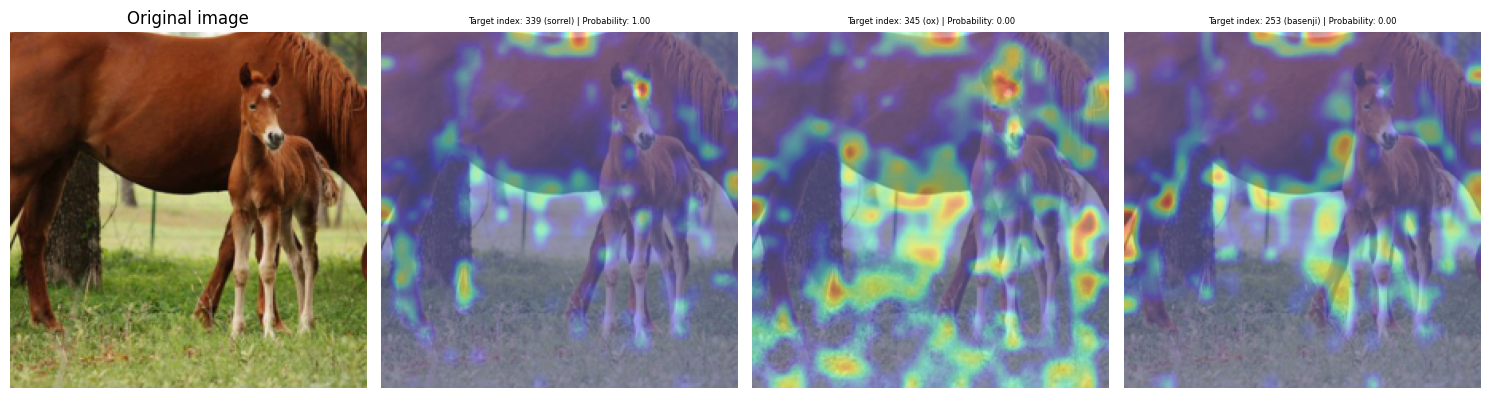

In [32]:
# test Grad_CAM
index = 10
heatmap = Grad_CAM_bis(resnet34, dataset[index][0].view(1, 3, 224, 224), layer="layer2")

##### What are the principal contributions of GradCAM (the answer is in the paper) ?